## **Import Libraries** ##

In [1]:
import os
import numpy as np
from tqdm import tqdm  # for the progress bar

## **Loading Feature Vectors and Their Labels** ##

In [2]:
# Function to Load Feature Vectors and Labels
def loadFeaturesAndLabels(features_path):

    features = [] # list to store the feature vectors
    labels = [] # list to store the labels
    
    # checking if the path exists
    if not os.path.exists(features_path):
        raise ValueError(f"Path {features_path} does not exist.")
    # checking if the path is a directory
    if not os.path.isdir(features_path):
        raise ValueError(f"Path {features_path} is not a directory.")
    
    # going through through the folders and load the features
    for fruit_folder in tqdm(os.listdir(features_path), unit="folder", desc=f"Loading Features from {features_path}"):

        fruit_folder_path = os.path.join(features_path, fruit_folder) # creating complete path of the fruit folder
        
        if os.path.isdir(fruit_folder_path):  # checking if it's an valid path to a folder
            for featureVectorFile in os.listdir(fruit_folder_path):

                feature_file_path = os.path.join(fruit_folder_path, featureVectorFile) # creating complete path of the feature file
                
                if featureVectorFile.endswith('.npy'):  # checking if its a valid feature file
                    labels.append(fruit_folder[:-2].strip())  # the folder name is the label (not taking the numbers at the end)

                    featureVector = np.load(feature_file_path)
                    features.append(featureVector)
                    
                    
    return np.array(features), np.array(labels)

In [3]:
# loading the train and test feature data and labels
trainFeatures, trainLabels = loadFeaturesAndLabels('../features/img_ColourHist_Features/Training')
testFeatures, testLabels = loadFeaturesAndLabels('../features/img_ColourHist_Features/Testing')

Loading Features from ../features/img_ColourHist_Features/Training: 100%|██████████| 161/161 [00:05<00:00, 29.44folder/s]
Loading Features from ../features/img_ColourHist_Features/Testing: 100%|██████████| 160/160 [00:01<00:00, 88.66folder/s]


## **Linear Discriminant Analysis (LDA)** ##

In [4]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
import joblib

# checking the shape of the features and labels
print(f"Training Features Shape: {trainFeatures.shape}")
print(f"Testing Features Shape: {testFeatures.shape}")
print(f"Number of Labels: {len(np.unique(trainLabels))}")

# training LDA
LDA_Model = LinearDiscriminantAnalysis()
LDA_Model.fit(trainFeatures, trainLabels)

# number of features in LDA
print(f"Number of Features in LDA: {LDA_Model.scalings_.shape[1]}")

# predicitng using only LDA
testPredictions_LDA = LDA_Model.predict(testFeatures)

# finding the accuracy
accuracy = accuracy_score(testLabels, testPredictions_LDA)
print(f"LDA Classifier Accuracy: {accuracy*100:.2f}%")

# saving the LDA model
lda_model_filename = '../saved_models/LDA_Model_1.pkl'
joblib.dump(LDA_Model, lda_model_filename)
print(f"LDA classifier model saved to {lda_model_filename}")


Training Features Shape: (79921, 960)
Testing Features Shape: (26668, 960)
Number of Labels: 132
Number of Features in LDA: 131
LDA Classifier Accuracy: 94.64%
LDA classifier model saved to ../saved_models/LDA_Model_1.pkl


## **LDA + Linear SVM** ##

Training Features Shape: (79921, 960)
Testing Features Shape: (26668, 960)
Number of Labels: 132
Number of Features in LDA: 960


/var/folders/fz/nfq5rtfs7yx0l6hq57j092ww0000gn/T/ipykernel_58515/2535937558.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(trainFeaturesLDA[:, 9], trainFeaturesLDA[:, 19], label='Train', marker = 'o', cmap='viridis')
/var/folders/fz/nfq5rtfs7yx0l6hq57j092ww0000gn/T/ipykernel_58515/2535937558.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(testFeaturesLDA[:, 9], testFeaturesLDA[:, 19], label='Test', marker='x', cmap='virdis')


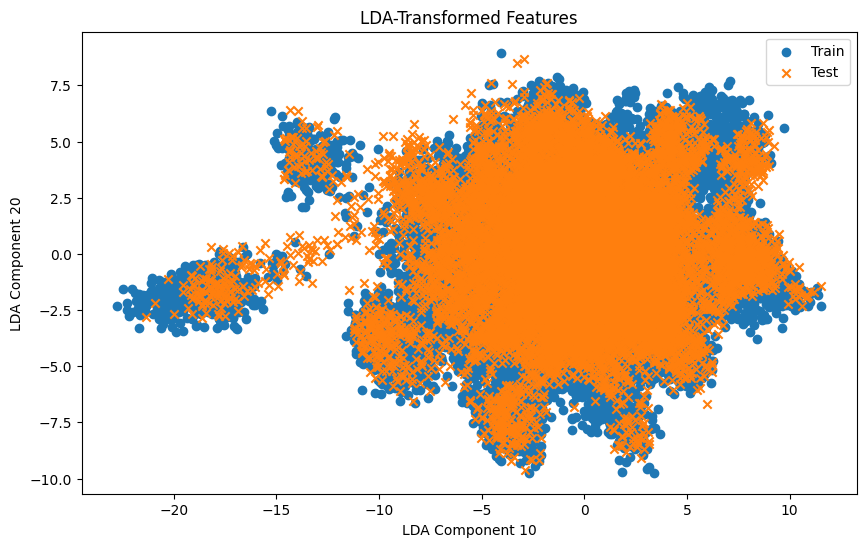

LDA + Linear SVM Accuracy: 98.90%
Image Index: 312 - Predicted: Cactus fruit green - Actual: Corn Husk
Image Index: 313 - Predicted: Pear Stone - Actual: Corn Husk
Image Index: 321 - Predicted: Pear Stone - Actual: Corn Husk
Image Index: 322 - Predicted: Pear Stone - Actual: Corn Husk
Image Index: 324 - Predicted: Watermelon - Actual: Corn Husk
SVM (LDA) model saved to ../saved_models/LDA_SVM_Model_1.pkl sucessfully


In [5]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import joblib

# checking the shape of the features and labels
print(f"Training Features Shape: {trainFeatures.shape}")
print(f"Testing Features Shape: {testFeatures.shape}")
print(f"Number of Labels: {len(np.unique(trainLabels))}")

# loading LDA
lda_model_filename = '../saved_models/LDA_Model_1.pkl'
LDA_Model = joblib.load(lda_model_filename)

# number of features in LDA
print(f"Number of Features in LDA: {LDA_Model.n_features_in_}")

# transforming training and testing features for SVM
trainFeaturesLDA = LDA_Model.transform(trainFeatures)
testFeaturesLDA = LDA_Model.transform(testFeatures)

# visualizing 2 LDA-transformed features 
plt.figure(figsize=(10, 6))
plt.scatter(trainFeaturesLDA[:, 9], trainFeaturesLDA[:, 19], label='Train', marker = 'o', cmap='viridis')
plt.scatter(testFeaturesLDA[:, 9], testFeaturesLDA[:, 19], label='Test', marker='x', cmap='virdis')
plt.title('LDA-Transformed Features')
plt.xlabel('LDA Component 10')
plt.ylabel('LDA Component 20')
plt.legend()
plt.show()

# training linear SVM model on the LDA-transformed features
LDA_SVM_Model = SVC(kernel='linear')
LDA_SVM_Model.fit(trainFeaturesLDA, trainLabels)

# making predictions on the test set
testPredictions_LDA_SVM = LDA_SVM_Model.predict(testFeaturesLDA)

# finding the accuracy
accuracy = accuracy_score(testLabels, testPredictions_LDA_SVM)
print(f"LDA + Linear SVM Accuracy: {accuracy*100:.2f}%")

# display 5 incorrectly classified images (also displaying the image index in testFeatures)
incorrectIndices = np.where(testPredictions_LDA_SVM != testLabels)[0][:5]
for i in incorrectIndices:
    print(f"Image Index: {i} - Predicted: {testPredictions_LDA_SVM[i]} - Actual: {testLabels[i]}")

# saving the model 
lda_svm_model_filename = '../saved_models/LDA_SVM_Model_1.pkl'
joblib.dump(LDA_SVM_Model, lda_svm_model_filename)
print(f"SVM (LDA) model saved to {lda_svm_model_filename} sucessfully")